## Capstone - Final Project

After analyzing the diaper manufacturing process, we can now move into the data modeling process. In this phase, we must do an extensive amount of data cleaning and exploratory analysis before we begin modeling. These steps will help us ensure that we understand the relationships and structure of the data we are dealing with. Then, we can move onto building benchmark models. These will be simpler models that we will run on our data that we can compare with the artificial neural networks that we intend to build later on. If our benchmark models perform well, we will have to make a business decision on whether it is worth the extra effort of productionizing a more complex neural network model.

In the first phase of our project, we will be doing the following:
- Join label and feature data
- Impute missing values
- Remove unnecessary columns
- Solve for class imbalance using SMOTE
- Apply feature selection methods to reduce data dimensionality
- Choose a performance metric

### Feature Set

The first set of data to load is our manufacturing sensor data. Each feature in this data set is a different sensor, providing us information on an observation.

In [1]:
#load data
#check data structure

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

data = np.loadtxt('data/secom.data')

print(data.shape)

(1567, 590)


In [2]:
secom = pd.DataFrame(data)
secom.head()

,0,1,2,3,4,5,6,7,8,9,...,580,581,582,583,584,585,586,587,588,589
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,NaN,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,0.0060,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,0.0148,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,0.0044,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,NaN,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432


Note that we have 590 different sensors/features and 1567 observations.

### Labels

The labels data set will help us build our supervised learning model. The target indicates whether a particular observation is faulty. We can use this information to train our models and then predict on a subset of the joined data set. Let's clean this data and then join it to our sensor data.

In [3]:
#read in labels data

with open('data/secom_labels.data', 'r') as f:
    labels = f.readlines()
    
print(labels[:3])

['-1 "19/07/2008 11:55:00"\n', '-1 "19/07/2008 12:32:00"\n', '1 "19/07/2008 13:17:00"\n']


We'll start by splitting each value in the list using the spaces, then replacing the double quotes with a single quote and stripping any other unnecessary spaces. 

In [4]:
#split by spaces

labels = [label.split(' ') for label in labels]

In [5]:
#replace double quotes and strip extra spaces

labels = [[entry.strip().replace('"', '') for entry in label] for label in labels]

In [6]:
#convert to dataframe

labels = pd.DataFrame(labels, columns = ['target', 'date', 'time'])
labels.head()

,target,date,time
0,-1,19/07/2008,11:55:00
1,-1,19/07/2008,12:32:00
2,1,19/07/2008,13:17:00
3,-1,19/07/2008,14:43:00
4,-1,19/07/2008,15:22:00


We now have a clean data frame of the three columns from the labels data set. Let's join this to the feature set.

In [7]:
#join labels to secom dataset

df = secom.join(labels)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,583,584,585,586,587,588,589,target,date,time
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,-1,19/07/2008,11:55:00
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,-1,19/07/2008,12:32:00
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1,19/07/2008,13:17:00
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,-1,19/07/2008,14:43:00
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,-1,19/07/2008,15:22:00


### Data Cleaning & Feature Engineering

With our data set in one piece, we can now focus on the null values in the data set. Since we are looking to find the most predictive features, we will likely not find signal in columns with an excessive number of missing values. Let's drop columns that have > 20% of the 1567 observations as null values, as we're highly unlikely to find any of these to be useful in the model.

In [8]:
#dropping columns with over 20% null values
drop_na = list(df.loc[:,df.isna().sum() > (df.count())*(1/5)].columns)
df.drop(drop_na, axis=1, inplace=True)

In [9]:
#delete date, time features

del[df['date']]
del[df['time']]

In [10]:
#replace -1 in target with 0

df['target'] = df['target'].replace('-1', 0)

Before we run any models, we need to split our data set into a train, validation, and test set. To understand whether the models we build can perform well in the future, they must be able to generalize well on unseen data. Splitting our data into three different sets is a way for us to measure how our models may perform going forward. Therefore, we will use 80% of our data set to train our model and then split the remaining 20% evenly into a test and validation set. The validation set will be used to tune our models' parameters, while the test set can tell us our how our chosen model performs on a data set it has not seen. Let's perform these steps next.

In [11]:
#drop target from X

X = df.drop(['target'], axis = 1)
y = df['target'].astype('int64')

In [12]:
#split into 80-20 train-val/test
#50-50 val/test

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 1)

X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size = 0.50, random_state = 1)

In [13]:
X_train = X_train.reset_index(drop = True)
X_valid = X_valid.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)

In [14]:
print('X train shape: {}'.format(X_train.shape))
print('X validation shape: {}'.format(X_valid.shape))
print('X test shape: {}'.format(X_test.shape))

X train shape: (1253, 550)
X validation shape: (157, 550)
X test shape: (157, 550)


Splitting our data into three sets left us with the data sets above. Notice how we have 550 features in each of our data sets. It is unlikely that most of these features will be predictive in our models. High dimensionality can also cause long run times. We will need to narrow down our feature set in later steps. Before doing this however, we must do two things. 

First, we have to impute missing values in each of our data sets. Second, we will need to standardize the numeric features in our data. Measurements in our data are likely to have different units and scales. To account for this, we must transform these features for them to be on the same scale. This is important when we run certain algorithms such as Support Vector Machines. After doing this, our data should have a mean centered near 0 and a standard deviation of ~1.

In [15]:
#fill missing values with the mean of the train set

for column in X_train.columns:
    X_train[column].fillna(X_train[column].mean(), inplace=True)
    X_valid[column].fillna(X_train[column].mean(), inplace=True)
    X_test[column].fillna(X_train[column].mean(), inplace=True)

In [16]:
#initialize standardscaler
#fit numeric columns
from sklearn.preprocessing import StandardScaler

znormalizer = StandardScaler()
znormalizer.fit(X_train)
X_train = pd.DataFrame(znormalizer.transform(X_train), columns = X_train.columns)
X_valid = pd.DataFrame(znormalizer.transform(X_valid), columns = X_valid.columns)
X_test = pd.DataFrame(znormalizer.transform(X_test), columns = X_test.columns)
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,576,577,582,583,584,585,586,587,588,589
0,-0.958601,0.927555,-0.213206,2.119234,-0.040224,0.0,-2.270271,0.145725,-0.562111,0.600802,...,4.793848,6.258281,-0.699295,0.051608,-0.089278,0.051607,2.667230,0.127941,-0.080762,-0.716431
1,-1.059148,0.038292,-2.912957,0.330101,-0.057009,0.0,-0.367259,0.535636,-0.241648,-0.671046,...,-0.226081,0.318446,0.399258,-0.384719,-0.355759,-0.371223,0.025725,-0.256531,-0.283599,-0.372816
2,-1.433404,0.754126,0.100630,2.788137,-0.053570,0.0,-2.381693,0.183458,-0.251034,-0.573212,...,-0.254379,0.291199,-0.439112,-0.006218,0.056075,-0.005771,-0.897211,0.204835,0.257299,0.801493
3,0.462736,-0.761869,0.418952,-0.654294,-0.066859,0.0,0.488114,-0.105831,1.316421,0.013795,...,-0.233396,-0.689358,-1.046207,-0.248038,-0.186181,-0.233365,-0.411874,1.665826,1.643351,0.956293
4,-0.299742,1.183426,0.760062,0.772441,-0.046513,0.0,-0.689508,0.271502,1.197086,-1.740703,...,-0.211346,-0.467898,1.121990,-0.016732,-0.040827,-0.021685,-0.395961,-0.377364,-0.486436,-0.228242


### Dealing with Class Imbalance

We need to check the distribution of our target variable before getting to feature selection and modeling. An imbalanced target can lead to biases in our predictions towards the majority class. 

In our case, we are dealing with defects in the manufacturing process. It's likely that the positive cases in such a problem are very low in proportion to the negative ones. Because we are more interested in the model identifying the minority class (when there is a defect in the manufacturing process), we need to pay special attention to the class imbalance problem in this data set. With a very small number of positive cases in the data set, the model we choose will likely have challenges predicting the minority class in the future because of the lack of historical examples we are feeding it.

Before we apply any methods to solve for class imbalance, let's look at the distribution of the target feature.

In [17]:
y_train.value_counts()

0    1169
1      84
Name: target, dtype: int64

This is clearly a very imbalanced data set with only 7% of the cases as positive (class 1). To balance the classes, we can use SMOTE to over sample the minority class (in this case, the defects). SMOTE will balance the number of observations in each class by manufacturing synthetic data using a kmeans clustering algorithm.

SMOTE is a widely used approach to synthesizing new examples in a data set. The algorithm selects a minority class at random, finds its k nearest minority class neighbor, and then creates a synthetic instance by choosing one of the k nearest neighbors at random to form a line segment in the feature space. SMOTE is useful to us because we should see a balanced set of positive and negative classes in our training data after it is applied.

In [20]:
#set number of k nearest neighbors
#fit on training data

from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=0, k_neighbors = 8)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [21]:
#check class distribution

y_train.value_counts()

1    1169
0    1169
Name: target, dtype: int64

Looks like SMOTE did its job. We can now get into feature selection. 

### Feature Selection

We're going to start by doing a simple mutual information classification to give us a subset of important features to use in our predictive model. Mutual information highlights important statistical dependencies within in our data set in the context of our target variable.

The definition for mutual information is provided below:

*A quantity called mutual information measures the amount of information one can obtain from one random variable given another*

Running a mutual information classification is an efficient way of selecting a set of features that can explain the target variable from a larger data set. After running this, we can use the subset of features chosen by the mutual information classification and run stepwise feature selection to iteratively select a smaller set of predictive features for our model. By using mutual information classification in our first step, our recursive feature elimination step that we perform later will be able to run more efficiently because we will have already narrowed down our features from the original data set.

In [22]:
#run mutual info classification
#convert output to list and show 125 highest mutual information features

from sklearn.feature_selection import mutual_info_classif
import heapq

mi_score = mutual_info_classif(np.array(X_train), y_train, random_state = 7)

mi = mi_score.tolist()
num = 125

m = heapq.nlargest(num, enumerate(mi), key = lambda mi: mi[1])

In [23]:
#see results

m

[(339, 0.46321581555281277),
 (148, 0.45945732504443204),
 (136, 0.4565686230546764),
 (544, 0.45546961832109356),
 (357, 0.44998797054176665),
 (157, 0.44896224092914205),
 (117, 0.4481753149306611),
 (124, 0.447054443809918),
 (358, 0.4458583564068188),
 (210, 0.4417919534892498),
 (229, 0.43959606281155805),
 (114, 0.4388671660010879),
 (116, 0.4371186120363839),
 (158, 0.4346239085716763),
 (7, 0.4285601553564853),
 (101, 0.4261521146190337),
 (264, 0.4261294043939048),
 (369, 0.423508657096513),
 (228, 0.42280702743167886),
 (347, 0.42044344057633065),
 (349, 0.42004693353013756),
 (122, 0.41651464100921376),
 (274, 0.4137487540999183),
 (102, 0.41326162395141974),
 (341, 0.413002343024075),
 (128, 0.4096012763178052),
 (548, 0.40787881750496324),
 (109, 0.4073240120382484),
 (97, 0.40729408501232567),
 (346, 0.4063690636146786),
 (348, 0.4051922764515923),
 (29, 0.40433035384893223),
 (55, 0.39834951473164537),
 (89, 0.39766110478238637),
 (268, 0.3887586755897876),
 (103, 0.3851

We now have the 125 features with the highest mutual information. We can use these features to subset our original data set before using a step wise feature selection method called recursive feature elimination (RFE).

Before moving to RFE, let's subset our features on the ones we selected.

In [24]:
X_col = [i[0] for i in m]
X_train = X_train.iloc[:, X_col]
X_train.head()

,357,155,143,584,376,166,124,131,377,219,...,560,587,447,170,441,58,561,95,443,17
0,0.203201,-0.203907,-0.823328,-0.089278,0.002389,-0.166872,-0.302392,0.704207,0.055307,0.326860,...,-0.094124,0.127941,-0.118287,-1.211436,-1.191871,0.497086,-0.027531,-0.557033,-0.484273,0.099967
1,-0.386447,-0.237469,0.279585,-0.355759,1.123169,-0.608406,-0.744683,-1.153850,0.504585,-0.331345,...,0.048701,-0.256531,0.990386,0.361430,0.429895,-1.085006,0.544045,-1.506193,-1.042203,0.214363
2,0.006652,-0.229079,-2.083800,0.056075,0.375982,1.246035,-2.071555,0.571488,-1.067890,0.147350,...,-0.522597,0.204835,1.290749,-1.025075,-0.981764,-0.684255,-0.408390,1.341287,1.605176,0.031329
3,0.596300,-0.212298,-0.193092,-0.186181,0.749576,-0.608406,-0.390850,0.969643,-0.843250,0.685881,...,3.461252,1.665826,1.381205,0.885292,0.870354,-0.433351,1.158870,-0.557033,0.132240,0.588056
4,1.185947,-0.237469,-0.980887,-0.040827,0.375982,0.098048,-1.275432,-0.578737,0.504585,1.463760,...,-0.050324,-0.377364,0.855861,-0.107356,-0.051601,1.494896,0.434010,0.392127,-1.572237,0.107593


In [25]:
#repeat for validation and test set

X_valid = X_valid.iloc[:, X_col]
X_test = X_test.iloc[:, X_col]

We are going to use recursive feature selection (RFE) random forest classifier to choose the best features from our subsetted data set. RFE is a wrapper style feature selection method that discards less important features and repeatedly refits the model until the specified set of features remain. Because this process can be computationally expensive, we will set our cross validation parameter to just 3. 

After running RFE, we can output a chart that will inform us on the optimal number of features to use before classification accuracy drops off.

**Note: Long run time**

In [26]:
#initialize random forest classifier
#set cvs and performance metric
#fit

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

rfc = RandomForestClassifier()
rfecv = RFECV(estimator=rfc, step=1, cv=StratifiedKFold(3), scoring='f1_weighted')
rfecv.fit(X_train, y_train)

RFECV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
      estimator=RandomForestClassifier(), scoring='f1_weighted')

We can now visualize the optimal number of features and then drop the least important set.

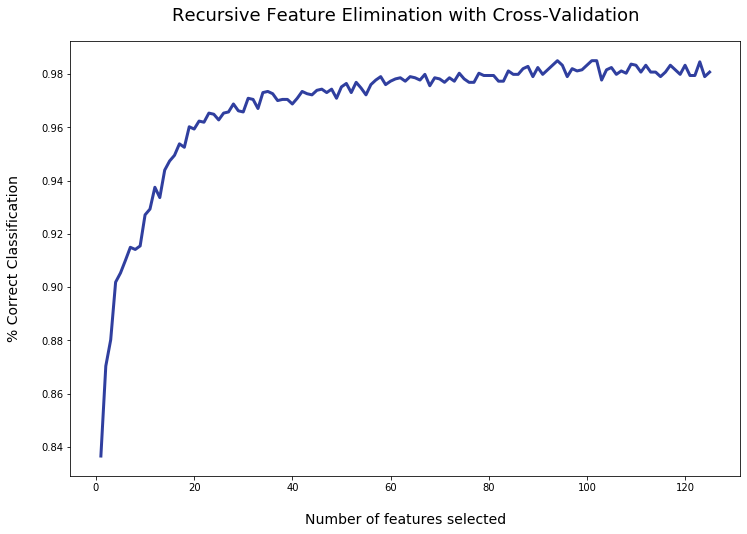

In [27]:
plt.figure(figsize=(12, 8))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)

plt.show()

In [28]:
#output unimportant features

print(np.where(rfecv.support_ == False)[0])

[ 20  22  39  43  47  48  67  68  70  71  78  82  84  86  94  98 100 101
 103 104 107 108 119 124]


The array above shows 19 sensors that RFE did not find to be predictive. We can now subset our data sets on the remaining features.

In [29]:
#store important features in RFE_col

back_features = pd.DataFrame(rfecv.support_)
sel_back = back_features[0].loc[back_features[0] == True]
RFE_col = sel_back.index.tolist()

In [30]:
#subset train, valid, test sets

X_train = X_train.iloc[:, RFE_col]
X_valid = X_valid.iloc[:, RFE_col]
X_test = X_test.iloc[:, RFE_col]

We can now output the results and see which features RFE chose for us.

In [31]:
#display new data frame
X_train.head()

,357,155,143,584,376,166,124,131,377,219,...,442,331,560,587,447,170,58,561,95,443
0,0.203201,-0.203907,-0.823328,-0.089278,0.002389,-0.166872,-0.302392,0.704207,0.055307,0.326860,...,-0.786655,0.313557,-0.094124,0.127941,-0.118287,-1.211436,0.497086,-0.027531,-0.557033,-0.484273
1,-0.386447,-0.237469,0.279585,-0.355759,1.123169,-0.608406,-0.744683,-1.153850,0.504585,-0.331345,...,-0.168723,0.189876,0.048701,-0.256531,0.990386,0.361430,-1.085006,0.544045,-1.506193,-1.042203
2,0.006652,-0.229079,-2.083800,0.056075,0.375982,1.246035,-2.071555,0.571488,-1.067890,0.147350,...,-0.617990,-0.080496,-0.522597,0.204835,1.290749,-1.025075,-0.684255,-0.408390,1.341287,1.605176
3,0.596300,-0.212298,-0.193092,-0.186181,0.749576,-0.608406,-0.390850,0.969643,-0.843250,0.685881,...,-0.185665,0.176933,3.461252,1.665826,1.381205,0.885292,-0.433351,1.158870,-0.557033,0.132240
4,1.185947,-0.237469,-0.980887,-0.040827,0.375982,0.098048,-1.275432,-0.578737,0.504585,1.463760,...,-0.052549,0.017298,-0.050324,-0.377364,0.855861,-0.107356,1.494896,0.434010,0.392127,-1.572237


### Initial Models

We are ready to begin modeling. We will begin by building a decision tree classifier before moving to random forest and SVM classifiers. The decision tree classifier will give us more intuition about the decision making within the model, where the most important splits are, and more information about the non linear relationships within the data set.

#### Decision Tree

Below, we trained a classifier using a greedy approach to parameter tuning. We incremented the max leaf node parameter by 1 until performance dropped off before using the same approach on the minimum sample leaf and split parameters. This left us with the parameters shown in the code block below.

In [32]:
#train decision tree
#predict on train and val
#print accuracy on both

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

dtree = DecisionTreeClassifier(min_samples_leaf = 2, max_leaf_nodes = 8, 
                               min_samples_split = 2, class_weight = 'balanced').fit(X_train, y_train)

y_dtree_train = dtree.predict(X_train) 
y_dtree_valid = dtree.predict(X_valid) 

print("Decision Tree accuracy on training set: {:.1f}%".format(accuracy_score(y_train, y_dtree_train)*100))
print("Decision Tree accuracy on validation set: {:.1f}%".format(accuracy_score(y_valid, y_dtree_valid)*100))

Decision Tree accuracy on training set: 79.4%
Decision Tree accuracy on validation set: 80.9%


Surprisingly, our validation accuracy was higher than our accuracy on the training set. To understand what is happening under the hood, we need to visualize our decision tree and then look at the precision and recall to get a better sense of how the model is classifying the positive cases.

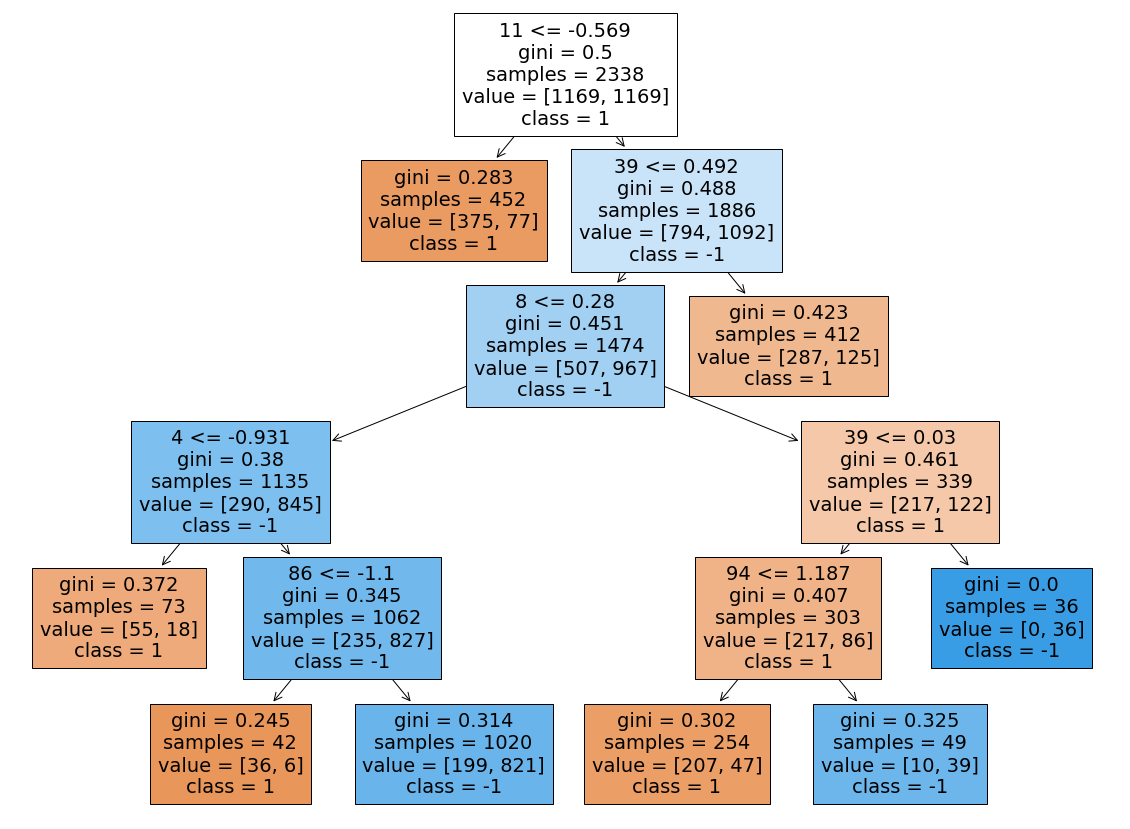

In [33]:
#plot decision tree

from sklearn import tree
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 15)) 
tree.plot_tree(dtree,
               feature_names=X.columns,  
               class_names=['1', '-1'],
               filled=True);

To understand the decision tree, we begin with the root node. This classifier uses the gini coefficient to determine each split. Notice how at the root node, we can see the highest gini coefficient of any node in the tree. This means that the feature identified in the root node is the most important according to our model. From this node, the model divides the classes evenly. The left split becomes a leaf/terminal node, where no further splits are made indicating that the model has made a final decision on these particular observations. The right split sends the rest of the observations down a deep path to figuring out which class they stand in.

With this understanding, we can now move onto getting a precision and recall score from our model. The purpose of both metrics is to better understand how our model is classifying the positive class.

In [34]:
#print precision/recall for train-val

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

precision_train = precision_score(y_train, y_dtree_train, pos_label = 1) * 100
precision_valid = precision_score(y_valid, y_dtree_valid, pos_label = 1) * 100
recall_train = recall_score(y_train, y_dtree_train, pos_label = 1) * 100
recall_valid = recall_score(y_valid, y_dtree_valid, pos_label = 1) * 100

print("Precision on training data: {:.1f}%.".format(precision_train))
print("Recall on training data: {:.1f}%.\n".format(recall_train))
print("Precision on validation data: {:.1f}%.".format(precision_valid))
print("Recall on validation data: {:.1f}%.".format(recall_valid))

Precision on training data: 81.1%.
Recall on training data: 76.6%.

Precision on validation data: 18.8%.
Recall on validation data: 60.0%.


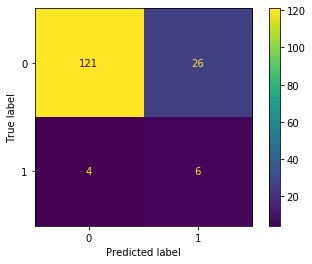

In [35]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(dtree, X_valid, y_valid);

In [36]:
from sklearn.metrics import roc_auc_score

print("Training AUC: {:.1f}%.".format(roc_auc_score(y_train, y_dtree_train)*100))
print("Validation AUC: {:.1f}%.".format(roc_auc_score(y_valid, y_dtree_valid)*100))

Training AUC: 79.4%.
Validation AUC: 71.2%.


The results above tell us that the model is over fitting to the training set. Both precision and recall drop off from train to validation, primarily due to class imbalance.

Let's implement a random forest next to see if we can get a more robust model. Random forest is less likely to overfit because it uses many small decision trees rather than only one to make its predictions. We will begin with a grid search to choose the optimal parameters for the model. The code block below has been commented out due to run time.

#### Random Forest

In [37]:
#set parameter grid
#initialize rf regressor
#perform grid search - 2 cvs
#print best parameters

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

#param_grid = {
#    'bootstrap': [True],
#    'max_depth': [10, None],
#    'max_features': [10, 12],
#    'n_estimators': [800, 1000]
#}

#rf = RandomForestRegressor()
#grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
#                          cv = 2, n_jobs = -1, verbose = 2)

#grid_search.fit(X_train, y_train)
#grid_search.best_params_

We can now use the parameters specified by the grid search to train our random forest classifier.

In [38]:
#use optimal parameters from grid search
#run rf classifier

from sklearn.ensemble import RandomForestClassifier

hypers = {"n_estimators": 1000, "max_features": 12, "max_depth": None, 
          "min_samples_leaf": 2, "min_samples_split": 2}
clf_rf = RandomForestClassifier(class_weight = 'balanced',
                                verbose = True, **hypers).fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   23.5s finished


In [39]:
#predict on train-val
#print accuracy

y_hat_train_rf = clf_rf.predict(X_train)
y_hat_valid_rf = clf_rf.predict(X_valid)

acc_train_rf = accuracy_score(y_train, y_hat_train_rf)
acc_val_rf = accuracy_score(y_valid, y_hat_valid_rf)

print('Train set random forest accuracy: {:.2f}%'.format(acc_train_rf * 100))
print('Validation set random forest accuracy: {:.2f}%'.format(acc_val_rf * 100))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Train set random forest accuracy: 100.00%
Validation set random forest accuracy: 94.27%


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.0s finished


We got much better accuracy on both the training and validation sets, as expected. Let's check our precision, recall, and output the AUC of this model.

In [40]:
#print precision/recall

precision_train_rf = precision_score(y_train, y_hat_train_rf, pos_label = 1) * 100
precision_valid_rf = precision_score(y_valid, y_hat_valid_rf, pos_label = 1) * 100
recall_train_rf = recall_score(y_train, y_hat_train_rf, pos_label = 1) * 100
recall_valid_rf = recall_score(y_valid, y_hat_valid_rf, pos_label = 1) * 100

print("Precision on training data: {:.1f}%".format(precision_train_rf))
print("Recall on training data: {:.1f}% \n".format(recall_train_rf))
print("Precision on validation data: {:.1f}%".format(precision_valid_rf))
print("Recall on validation data: {:.1f}%".format(recall_valid_rf))

Precision on training data: 100.0%
Recall on training data: 100.0% 

Precision on validation data: 60.0%
Recall on validation data: 30.0%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.0s finished


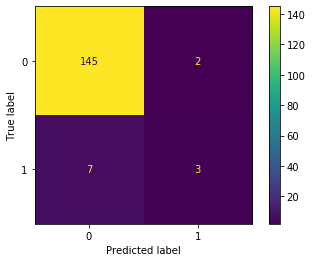

In [41]:
plot_confusion_matrix(clf_rf, X_valid, y_valid);

In [42]:
print("Training AUC: {:.1f}%.".format(roc_auc_score(y_train, y_hat_train_rf)*100))
print("Validation AUC: {:.1f}%.".format(roc_auc_score(y_valid, y_hat_valid_rf)*100))

Training AUC: 100.0%.
Validation AUC: 64.3%.


Once again, we are seeing a large drop from train to validation sets. This model however, is more precise than the decision tree, but was unable to identify 7 out of the 10 positive cases.

Let's see what features the model is highlighting by looking at a feature importance table. We can use this to compare it with our original decision tree to see how it might differ.

In [43]:
#display top 5 features from rf

var_imp = pd.DataFrame({"feature": X_train.columns, "importance": clf_rf.feature_importances_})
var_imp.sort_values(by = 'importance', ascending = False).head(5)

,feature,importance
11,121,0.041079
57,33,0.030135
46,130,0.027720
39,101,0.026598
8,377,0.026264


Some differences, but the top feature is the same in both the decision tree and random forest, as we might expect.

#### Support Vector Machine

Next, we can try an SVM before finalizing a model. We should expect the SVM to perform fairly well on sparse data with class imbalance such as what we have. Let's see how it performs.

In [44]:
#initialize svm
#predict on train, validation
#print accuracy

from sklearn.svm import SVC

svmc = SVC(C = 1.2, gamma = 'scale', kernel = 'rbf', class_weight = 'balanced')
svmc.fit(X_train, y_train)

y_hat_train_svm = svmc.predict(X_train)
y_hat_valid_svm = svmc.predict(X_valid)

acc_train_svm = accuracy_score(y_train, y_hat_train_svm)
acc_val_svm = accuracy_score(y_valid, y_hat_valid_svm)

print('Train set svm accuracy: {:.2f}%'.format(acc_train_svm * 100))
print('Validation set svm accuracy: {:.2f}%'.format(acc_val_svm * 100))

Train set svm accuracy: 99.83%
Validation set svm accuracy: 95.54%


The SVM has a higher validation set accuracy than the random forest did. This should translate into better precision and recall as well. Let's check this and then finalize an initial model.

In [45]:
precision_train_svm = precision_score(y_train, y_hat_train_svm, pos_label = 1) * 100
precision_valid_svm = precision_score(y_valid, y_hat_valid_svm, pos_label = 1) * 100
recall_train_svm = recall_score(y_train, y_hat_train_svm, pos_label = 1) * 100
recall_valid_svm = recall_score(y_valid, y_hat_valid_svm, pos_label = 1) * 100

print("Precision on training data: {:.1f}%".format(precision_train_svm))
print("Recall on training data: {:.1f}% \n".format(recall_train_svm))
print("Precision on validation data: {:.1f}%".format(precision_valid_svm))
print("Recall on validation data: {:.1f}%".format(recall_valid_svm))

Precision on training data: 99.7%
Recall on training data: 100.0% 

Precision on validation data: 66.7%
Recall on validation data: 60.0%


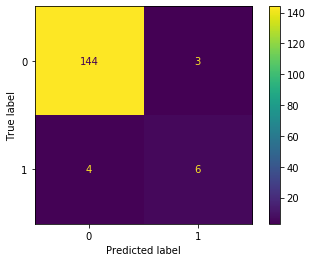

In [46]:
plot_confusion_matrix(svmc, X_valid, y_valid);

In [47]:
print("Training AUC: {:.1f}%.".format(roc_auc_score(y_train, y_hat_train_svm)*100))
print("Validation AUC: {:.1f}%.".format(roc_auc_score(y_valid, y_hat_valid_svm)*100))

Training AUC: 99.8%.
Validation AUC: 79.0%.


The SVM performed the best out of the benchmark models on the validation set, achieving 67% precision and 60% recall, outperforming the random forest on both metrics. SVMs perform quite well on sparse data sets, so this is unsurprising. With a 79% AUC, we can be quite satisfied with our best benchmark model, as we move onto building our neural networks. If they cannot score better than the SVM, our decision on the final model will be simple.

### Final Models

#### Fully Connected MLP Classifier

We'll begin by using a simple MLP (Multi-layer Perceptron) Classifier in Sklearn. The parameters below have been optimized using a greedy approach and testing on the validation set. We iterated on activation functions, depth of architecture, epochs, and different solvers optimizing for the log-loss function (cross entropy loss in our case).

In [48]:
#use greedy approach to parameter setting
#default loss is cross entropy

from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(50, 15), max_iter=100, alpha=0.0001,
                    solver='adam', activation='relu', batch_size= 150, verbose=10, random_state=1,
                    n_iter_no_change=10, tol=0.0001)

mlp.fit(X_train, y_train)

Iteration 1, loss = 0.65959340
Iteration 2, loss = 0.53098084
Iteration 3, loss = 0.45681450
Iteration 4, loss = 0.39989936
Iteration 5, loss = 0.35044127
Iteration 6, loss = 0.30878084
Iteration 7, loss = 0.27059346
Iteration 8, loss = 0.23540713
Iteration 9, loss = 0.20346604
Iteration 10, loss = 0.17548077
Iteration 11, loss = 0.15124649
Iteration 12, loss = 0.12961620
Iteration 13, loss = 0.11083784
Iteration 14, loss = 0.09441975
Iteration 15, loss = 0.08157427
Iteration 16, loss = 0.06986265
Iteration 17, loss = 0.05962337
Iteration 18, loss = 0.05120206
Iteration 19, loss = 0.04481404
Iteration 20, loss = 0.03878737
Iteration 21, loss = 0.03320420
Iteration 22, loss = 0.02929438
Iteration 23, loss = 0.02531880
Iteration 24, loss = 0.02237705
Iteration 25, loss = 0.01972432
Iteration 26, loss = 0.01748274
Iteration 27, loss = 0.01563463
Iteration 28, loss = 0.01413094
Iteration 29, loss = 0.01274398
Iteration 30, loss = 0.01121874
Iteration 31, loss = 0.01021221
Iteration 32, los

MLPClassifier(batch_size=150, hidden_layer_sizes=(50, 15), max_iter=100,
              random_state=1, verbose=10)

Text(0.5, 1.0, 'Loss Curve')

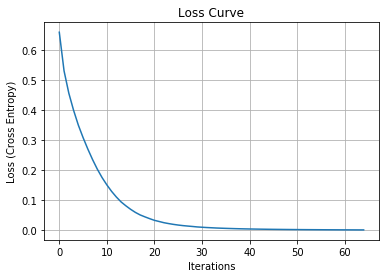

In [49]:
plt.plot(mlp.loss_curve_)
plt.grid()
plt.xlabel('Iterations')
plt.ylabel('Loss (Cross Entropy)')
plt.title('Loss Curve')

The loss curve allows us to see where performance tails off. After the 35th iteration or so, cross entropy loss begins to flat line. We continued for ~25 iterations after that point because of the class imbalance in the data set. Every positive missclassification is more costly than the negative cases. Beyond the 65th iteration, we saw no improvement in the validation AUC.

Our final parameters in our MLP classifier are as follows:

- Layer 1: 50
- Layer 2: 15
- 65 Iterations/Epochs
- 150 Batches
- Activation Function: Relu
- Solver: Adam

The parameters used in this classifier can provide a starting point in our next model that we will build using TensorFlow, so we will keep them in mind. Let's look at our performance metrics.

In [50]:
print("Training set score: {:.4f}".format(mlp.score(X_train, y_train)))
print("Validation set score: {:.4f}".format(mlp.score(X_valid, y_valid)))

Training set score: 1.0000
Validation set score: 0.9427


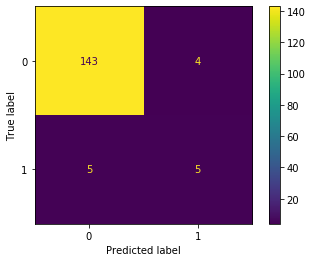

In [51]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(mlp, X_valid, y_valid);

In [52]:
y_hat_train_mlp = mlp.predict(X_train)
y_hat_valid_mlp = mlp.predict(X_valid)

In [53]:
precision_train_mlp = precision_score(y_train, y_hat_train_mlp, pos_label = 1) * 100
precision_valid_mlp = precision_score(y_valid, y_hat_valid_mlp, pos_label = 1) * 100
recall_train_mlp = recall_score(y_train, y_hat_train_mlp, pos_label = 1) * 100
recall_valid_mlp = recall_score(y_valid, y_hat_valid_mlp, pos_label = 1) * 100

print("Precision on training data: {:.1f}%".format(precision_train_mlp))
print("Recall on training data: {:.1f}% \n".format(recall_train_mlp))
print("Precision on validation data: {:.1f}%".format(precision_valid_mlp))
print("Recall on validation data: {:.1f}%".format(recall_valid_mlp))

Precision on training data: 100.0%
Recall on training data: 100.0% 

Precision on validation data: 55.6%
Recall on validation data: 50.0%


In [54]:
print("Training AUC: {:.1f}%.".format(roc_auc_score(y_train, y_hat_train_mlp)*100))
print("Validation AUC: {:.1f}%.".format(roc_auc_score(y_valid, y_hat_valid_mlp)*100))

Training AUC: 100.0%.
Validation AUC: 73.6%.


Our MLP classifier performed quite well, but did not outperform the SVM we chose from our initial models. Both models performed almost equally well on precision and recall, which is a positive sign. Before we move onto the Tensorflow model, where we will test a deeper architecture, let's check the F1 scores for both our MLP and SVM classifiers. The F1 score provides a weighted average measure of the precision and recall scores we see above.

In [55]:
from sklearn.metrics import f1_score

f1_train_mlp = f1_score(y_train, y_hat_train_mlp, pos_label = 1) * 100
f1_valid_mlp = f1_score(y_valid, y_hat_valid_mlp, pos_label = 1) * 100

f1_train_svm = f1_score(y_train, y_hat_train_svm, pos_label = 1) * 100
f1_valid_svm = f1_score(y_valid, y_hat_valid_svm, pos_label = 1) * 100

print("MLP F1 on training data: {:.1f}%".format(f1_train_mlp))
print("MLP F1 on validation data: {:.1f}% \n".format(f1_valid_mlp))
print("SVM F1 on training data: {:.1f}%".format(f1_train_svm))
print("SVM F1 on validation data: {:.1f}% \n".format(f1_valid_svm))

MLP F1 on training data: 100.0%
MLP F1 on validation data: 52.6% 

SVM F1 on training data: 99.8%
SVM F1 on validation data: 63.2% 



Given the results so far, the SVM is still the top choice. Using our knowledge from the MLP classifier built above though, let's see if we can improve performance by introducing more layers into the neural network and apply a regularization method to help with overfitting.

#### Tensorflow Dense Network with Dropout

Tensorflow will require us to convert our data frames into numpy arrays. Let's do that first and then we can tune our hyperparameters.

In [56]:
#convert datasets to numpy arrays

X_train = np.array(X_train)
X_valid = np.array(X_valid)
X_test = np.array(X_test)

In [57]:
y_train = np.array(y_train)
y_valid = np.array(y_valid)
y_test = np.array(y_test)

In [58]:
print('Train Set Shape:', X_train.shape)
print('Validation Set Shape:', X_valid.shape)
print('Test Set Shape:', X_test.shape)

print('Train Labels Shape:', y_train.shape)
print('Validation Labels Shape:', y_valid.shape)
print('Test Labels Shape:', y_test.shape)

Train Set Shape: (2338, 101)
Validation Set Shape: (157, 101)
Test Set Shape: (157, 101)
Train Labels Shape: (2338,)
Validation Labels Shape: (157,)
Test Labels Shape: (157,)


The below parameters have been iteratively tuned according to performance on the validation set. The model built uses 4 layers with the sizes shown below, a learning rate of 0.001, 412 batch size, and 9 iterations/epochs. We tuned the model until we reached convergence between the training and validation sets.

In [69]:
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout

#-------------------------
# Set some hyper parameters
#-------------------------

# Total number of training epochs
epochs = 9

# Training batch size
batch_size = 412

# The optimization initial learning rate
learning_rate = 0.001

# Hidden layer sizes
h_layer_seq = [50, 15, 5, 2]
final_count = 1

# x-data feature size
n_features = X_train.shape[1]

We added a 10% drop out rate that forces the model to work harder to find different paths in predicting the target. This prevents overfitting because each node in our model cannot rely on the output of other nodes. Setting the parameter to 10%, drops 10% of input elements, leaving more pressure on other nodes to perform during the training process. We determined this rate after 3 iterations on the validation set using 5, 10, and 20% dropout rates.

In [70]:
# Initialize a "sequential model" with tf.keras
model = tf.keras.Sequential()

# Add layers sequentially
for h_ix, h_num in enumerate(h_layer_seq):
    if h_ix == 0:
        # Need to set input Dimensions
        model.add(Dense(h_num, activation='relu', kernel_initializer='random_normal', input_shape=(n_features,)))
    else:
        model.add(Dense(h_num, activation='relu', kernel_initializer='random_normal'))
        # Add dropout!
        model.add(Dropout(rate=0.1))


# Add final output
model.add(Dense(final_count, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 50)                5100      
_________________________________________________________________
dense_6 (Dense)              (None, 15)                765       
_________________________________________________________________
dropout_3 (Dropout)          (None, 15)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 80        
_________________________________________________________________
dropout_4 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 12        
_________________________________________________________________
dropout_5 (Dropout)          (None, 2)                

Next, we will set up an optimizer that implements the Adam algorithm. The Adam optimizer is a stochastic gradient descent method that looks to minimize, in our case, binary cross entropy loss.

In [71]:
# Setup / Compile model
# Setup model with ADAM optimization & binary cross entropy loss

my_optmizer = tf.keras.optimizers.Adam(
    learning_rate=learning_rate, beta_1=0.8, beta_2=0.99, epsilon=1e-07, amsgrad=False,
    name='Adam')
model.compile(optimizer=my_optmizer, loss='binary_crossentropy', metrics=['AUC'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 50)                5100      
_________________________________________________________________
dense_6 (Dense)              (None, 15)                765       
_________________________________________________________________
dropout_3 (Dropout)          (None, 15)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 80        
_________________________________________________________________
dropout_4 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 12        
_________________________________________________________________
dropout_5 (Dropout)          (None, 2)                

We are now ready to fit the model with the parameters specified above and evaluate our validation set AUC results.

In [72]:
model_logs = model.fit(X_train, y_train,
                       epochs=epochs, batch_size=batch_size,
                       validation_data=(X_valid, y_valid), verbose=1)

Epoch 1/9
6/6 [==============================] - 0s 37ms/step - loss: 0.6931 - auc: 0.5000 - val_loss: 0.6930 - val_auc: 0.5000
Epoch 2/9
6/6 [==============================] - 0s 5ms/step - loss: 0.6929 - auc: 0.5000 - val_loss: 0.6914 - val_auc: 0.5000
Epoch 3/9
6/6 [==============================] - 0s 5ms/step - loss: 0.6924 - auc: 0.5950 - val_loss: 0.6896 - val_auc: 0.6065
Epoch 4/9
6/6 [==============================] - 0s 6ms/step - loss: 0.6915 - auc: 0.6829 - val_loss: 0.6872 - val_auc: 0.6786
Epoch 5/9
6/6 [==============================] - 0s 5ms/step - loss: 0.6895 - auc: 0.7650 - val_loss: 0.6823 - val_auc: 0.7735
Epoch 6/9
6/6 [==============================] - 0s 5ms/step - loss: 0.6865 - auc: 0.8019 - val_loss: 0.6759 - val_auc: 0.7830
Epoch 7/9
6/6 [==============================] - 0s 5ms/step - loss: 0.6819 - auc: 0.8431 - val_loss: 0.6676 - val_auc: 0.7922
Epoch 8/9
6/6 [==============================] - 0s 6ms/step - loss: 0.6750 - auc: 0.8621 - val_loss: 0.6555 -

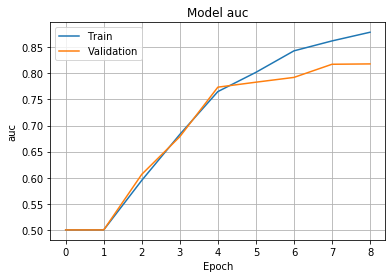

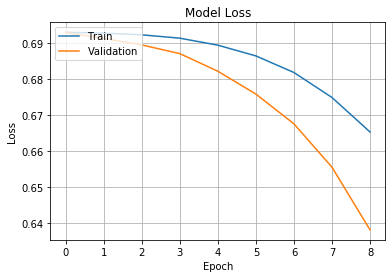

In [74]:
# Plot auc
plt.plot(model_logs.history['auc'])
plt.plot(model_logs.history['val_auc'])
plt.title('Model auc')
plt.ylabel('auc')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid()
plt.show()
# plot loss
plt.plot(model_logs.history['loss'])
plt.plot(model_logs.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid()
plt.show()

We can see that the model converges at epoch 5. The AUC we achieved with this model outperforms our SVM. Next, we can check the precison and recall on this model and then move onto choosing a final model.

In [75]:
tf_train_prob = model.predict(X_train)
tf_valid_prob = model.predict(X_valid)

In [76]:
#set probabilities > 50% to 1

y_hat_train_tf = (tf_train_prob > 0.5)*1
y_hat_valid_tf = (tf_valid_prob > 0.5)*1

In [77]:
model.evaluate(X_valid, y_valid, verbose = 1)

5/5 [==============================] - 0s 997us/step - loss: 0.6381 - auc: 0.8180


[0.6380723118782043, 0.8180272579193115]

In [78]:
#generate confusion matrix

from sklearn.metrics import confusion_matrix

train_cmatrix = confusion_matrix(y_train, y_hat_train_tf)
valid_cmatrix = confusion_matrix(y_valid, y_hat_valid_tf)

In [79]:
#create & print precision-recall variables

tf_precision_train = train_cmatrix[1][1]/(train_cmatrix[1][1] + train_cmatrix[0][1])*100
tf_recall_train = train_cmatrix[1][1]/(train_cmatrix[1][1] + train_cmatrix[1][0])*100
tf_precision_valid = valid_cmatrix[1][1]/(valid_cmatrix[1][1] + valid_cmatrix[0][1])*100
tf_recall_valid = valid_cmatrix[1][1]/(valid_cmatrix[1][1] + valid_cmatrix[1][0])*100
print("Train set precision: {:.1f}%".format(tf_precision_train))
print("Train set recall: {:.1f}% \n".format(tf_recall_train))
print("Validation set precision: {:.1f}%".format(tf_precision_valid))
print("Validation set recall: {:.1f}%".format(tf_recall_valid))

Train set precision: 90.4%
Train set recall: 80.9% 

Validation set precision: 29.2%
Validation set recall: 70.0%


With the light number of positive samples in the validation set, we can be quite satisfied with these results. The TF model with dropout was able to achieve 70% recall, but only 29% precision. The AUC of 81% outperformed any of our previous models. Before finalizing our model for predicting faulty products, we can test the SVM and the TF model with dropout on the left over test set. While we cannot make any more model/data related adjustments, we can gain more clarity on how both models generalize, given an unseen data set.

### Choosing a Final Model

We'll start by checking the SVM's performance metrics.

In [80]:
y_hat_test_svm = svmc.predict(X_test)
acc_test_svm = accuracy_score(y_test, y_hat_test_svm)

print('Test set svm accuracy: {:.2f}%'.format(acc_test_svm * 100))

Test set svm accuracy: 90.45%


In [81]:
recall_test_svm = recall_score(y_test, y_hat_test_svm, pos_label = 1) * 100
precision_test_svm = precision_score(y_test, y_hat_test_svm, pos_label = 1) * 100

print("Precision on test data: {:.1f}%".format(precision_test_svm))
print("Recall on test data: {:.1f}%".format(recall_test_svm))

Precision on test data: 14.3%
Recall on test data: 10.0%


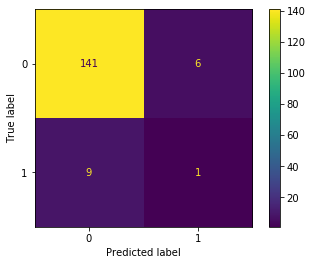

In [82]:
plot_confusion_matrix(svmc, X_test, y_test);

In [83]:
print("Validation AUC: {:.1f}%.".format(roc_auc_score(y_test, y_hat_test_svm)*100))

Validation AUC: 53.0%.


The SVM is showing significant variance between train, validation, and test sets. With an AUC of only 53%, the model performs hardly better than a coin flip. Both precision and recall were near zero. This should make our decision simple. Let's see how our TF model with dropout performs.

In [84]:
tf_test_prob = model.predict(X_test)
y_hat_test_tf = (tf_test_prob > 0.5)*1

In [85]:
model.evaluate(X_test, y_test, verbose = 1)

5/5 [==============================] - 0s 998us/step - loss: 0.6373 - auc: 0.7000


[0.6372652649879456, 0.699999988079071]

In [86]:
test_cmatrix = confusion_matrix(y_test, y_hat_test_tf)
tf_precision_test = test_cmatrix[1][1]/(test_cmatrix[1][1] + test_cmatrix[0][1])*100
tf_recall_test = test_cmatrix[1][1]/(test_cmatrix[1][1] + test_cmatrix[1][0])*100

print("Test set precision: {:.1f}%".format(tf_precision_test))
print("Test set recall: {:.1f}%".format(tf_recall_test))

Test set precision: 15.8%
Test set recall: 30.0%


With an AUC of 70%, the TF model significantly outperforms the SVM and is the clear choice from the models we have built.

### Conclusion

To summarize findings from our data models and analysis, a few important elements standout. Of the models built in this process, the Tensorflow model with dropout proved to be the most robust. Having said that, all of the models shown here were extremely sensitive to minor changes in parameters, among other things. There was also noticeable overfitting regardless of model. 

While our final model was able to achieve a 70% AUC on the test set, the model's performance may not be reliable enough to put into production. With 1567 total observations and only ~7% of them, as defective; the models were not able to produce consistent results on unseen data. This is concerning for a variety of reasons. For one, we will likely run into many false negatives and positives in production that could be very costly to the organization. There is also the investment risk associated with building processes around an unreliable 'black box' model. If the model performs worse than expected and it is not interpretable, the return on time and effort will not be adequate, given the resources typically required for such projects.

To optimize the diaper manufacturing process, we suggest collecting more data and re-running the models built here. More samples (especially positive samples) will allow our models to gain a better understanding of the underlying structure and relationships between the sensor data and the product quality. If more data is not an option, it may be worth building a simple rule based classifier using what we have learned about the sensor data already. Through our decision tree and random forest classifiers, we identified the most important sensors above. Using these sensors idenitifed by our models and related domain knowledge, a rule based classifier could perform moderately well, while being more interpretable for decision makers.